In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.7 MB/s eta 0:00:0000:0100:02
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=e91e5c8c780df4604806177cd3e9de9853bc312f4c102fb1aa0e5722ce0165b3
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ML") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 16:15:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read the CSV file
df = spark.read.csv("/kaggle/input/mlmodel/big_processed_data.csv", header=True, inferSchema=True)

# Show the first few rows
df.show(5)

24/09/24 16:16:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------+--------------------+--------+-------------------+--------------------+--------------------+------------------+-------------------------+-----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|                 amt|gender|            city_pop|is_fraud|                age|          trans_hour|category_food&health|category_household|category_shopping&grocery|category_transportation|state_AL|state_AR|state_AZ|state_CA|state_CO|state_CT|state_DC|state_DE|state_FL|state_GA|state_HI|state_IA|state_ID|state_IL|state_IN|state_KS|state_KY|state_LA|state_M

In [4]:
# Group by the 'is_fraud' column and count occurrences of each value
df.groupBy('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   9651|
|       0|1842743|
+--------+-------+



In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col  # Ensure this line is present
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report


In [6]:
!pip install xgboost imbalanced-learn
from pyspark.sql.functions import col
import pandas as pd
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
# Split the dataset into training and testing data
train, test = df.randomSplit([0.8, 0.2], seed=123)


In [8]:
# Convert training and testing data to Pandas
train_pd = train.toPandas()
test_pd = test.toPandas()

# Separate features and labels
X_train = train_pd.drop(columns=['is_fraud'])
y_train = train_pd['is_fraud']

X_test = test_pd.drop(columns=['is_fraud'])
y_test = test_pd['is_fraud']


In [9]:
# Calculate scale_pos_weight
num_majority = len(train_pd[train_pd['is_fraud'] == 0])
num_minority = len(train_pd[train_pd['is_fraud'] == 1])

scale_pos_weight = num_majority / num_minority
print(f'scale_pos_weight: {scale_pos_weight}')


scale_pos_weight: 192.01511203751954


In [10]:
from xgboost import XGBClassifier

# Train an XGBoost classifier with scale_pos_weight to handle imbalance
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)


In [11]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {auc}')


Accuracy: 0.9844178959574984
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    368835
           1       0.25      0.95      0.39      1975

    accuracy                           0.98    370810
   macro avg       0.62      0.97      0.69    370810
weighted avg       1.00      0.98      0.99    370810

ROC-AUC: 0.9677417623365256


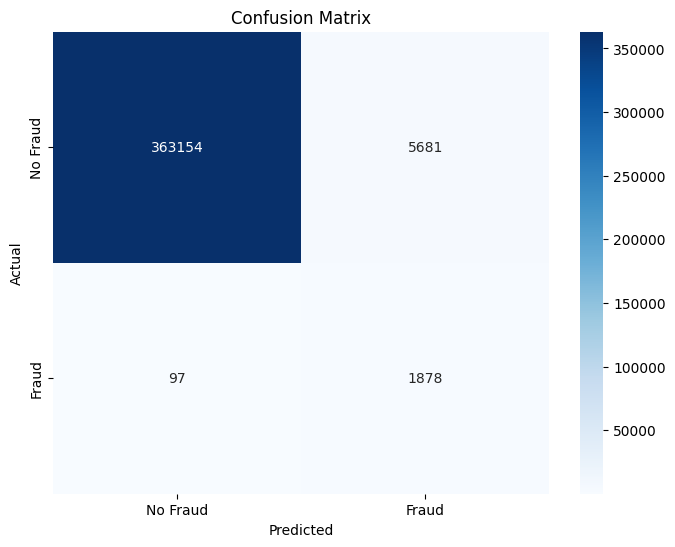

In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are defined
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


ROC-AUC: 0.9677417623365256


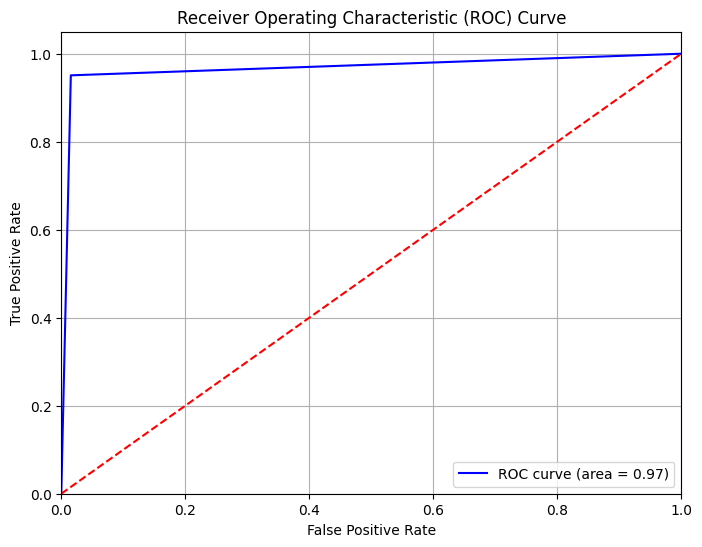

In [17]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Compute AUC-ROC score
auc = roc_auc_score(y_test, y_pred)  # Use predicted probabilities for AUC
print(f'ROC-AUC: {auc}')

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()